<a href="https://colab.research.google.com/github/anniebritton/Eco-Drought-South-Dakota/blob/main/Initial_Data_Acquisition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# installs and import libraries
!pip install earthengine-api --upgrade
!pip install geemap
!pip install geopandas 
!pip install matplotlib

import ee
import geemap.foliumap as geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

In [ ]:
# initialise ee, copy and paste the authentication code
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

In [3]:
# mount gogole drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# import and create a variable for the shapefile
AOI_path = '/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/Shapefiles/Cheyenne_Basin/Cheyenne_Basin_whole.shp'

# convert the shapefile into an Earth Engine object
AOI = geemap.shp_to_ee(AOI_path)

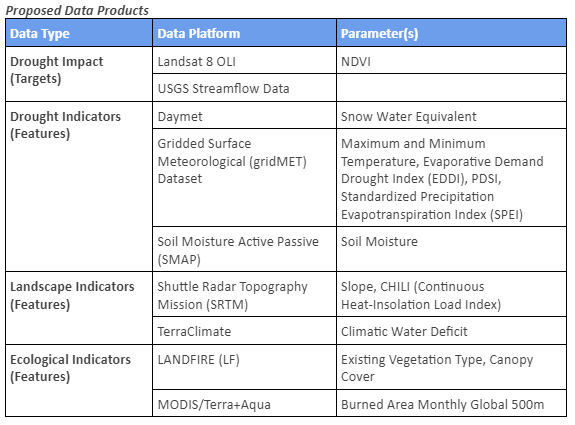

**Setting up the cloud masking and preprocessing for the MODIS NDVI Data**

In [5]:
# First, a function to mask out cloudy pixels
def mask_clouds(image):
    # Select the QA band
    QA = image.select('state_1km')
    # Make a mask to get bit 10, the internal_cloud_algorithm_flag bit
    bit_mask = 1 << 10
    # Return an image masking out cloudy areas
    return image.updateMask(QA.bitwiseAnd(bit_mask).eq(0))

# Get MODIS surface reflectance image collection
mod09ga = ee.ImageCollection('MODIS/006/MOD09GA')

# Filter image collections by date and apply the mask_clouds function
mod09ga_masked = mod09ga.filterDate('2000-02-24', '2021-12-31').map(mask_clouds)

In [6]:
# Next, a function to calculate and create a new NDVI band
def get_NDVI(imagecol):
    ndvi = imagecol.normalizedDifference(['sur_refl_b02', 'sur_refl_b01']).rename("NDVI")
    return imagecol.addBands(ndvi).select('NDVI').copyProperties(imagecol)

# Add NDVI as a band to the image
mod09ga_NDVI = mod09ga_masked.map(get_NDVI)

**Data Set Up**

In [18]:
# MODIS NDVI
NDVI_list = [mod09ga_NDVI, 'NDVI', AOI, 1000 ]
PP_NDVI_list = [ee.ImageCollection("MODIS/MOD09GA_006_NDVI").filterDate('2000-02-24','2021-12-31'), 'NDVI', AOI, 463.313] 

# Daymet
swe_list = [ee.ImageCollection("NASA/ORNL/DAYMET_V4").filterDate('1980-01-01','2021-12-31'), 'swe', AOI, 1000]

# gridMET Meteorology
tmin_list = [ee.ImageCollection("IDAHO_EPSCOR/GRIDMET").filterDate('1980-01-01','2021-12-31'), 'tmmn', AOI, 4638.3]
tmax_list = [ee.ImageCollection("IDAHO_EPSCOR/GRIDMET").filterDate('1980-01-01','2021-12-31'), 'tmmx', AOI, 4638.3]
precip_list = [ee.ImageCollection("IDAHO_EPSCOR/GRIDMET").filterDate('1980-01-01','2021-12-31'), 'pr', AOI, 4638.3]

# gridMET Drought
pdsi_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('1980-01-01','2021-12-31'), 'pdsi', AOI, 4638.3]

spei30_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('1980-01-01','2021-12-31'), 'spei30d', AOI, 4638.3]
spei90_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('1980-01-01','2021-12-31'), 'spei90d', AOI, 4638.3]
spei180_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('1980-01-01','2021-12-31'), 'spei180d', AOI, 4638.3]

spi30_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('1980-01-01','2021-12-31'), 'spi30d', AOI, 4638.3]
spi90_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('1980-01-01','2021-12-31'), 'spi90d', AOI, 4638.3]
spi180_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('1980-01-01','2021-12-31'), 'spi180d', AOI, 4638.3]

eddi30_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('1980-01-01','2021-12-31'), 'eddi30d', AOI, 4638.3]
eddi90_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('1980-01-01','2021-12-31'), 'eddi90d', AOI, 4638.3]
eddi180_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('1980-01-01','2021-12-31'), 'eddi180d', AOI, 4638.3]

# SMAP
smam_list = [ee.ImageCollection("NASA/SMAP/SPL3SMP_E/005").filterDate('2015-03-31','2021-12-31'), 'soil_moisture_am', AOI, 9000]
smpm_list = [ee.ImageCollection("NASA/SMAP/SPL3SMP_E/005").filterDate('2015-03-31','2021-12-31'), 'soil_moisture_pm', AOI, 9000]

**Function for Creating a Timeseries of Spatially Averaged Data**

In [93]:
def spatialtimeseries(datalist):
  
    data = datalist[0]
    band = datalist[1]
    geometry = datalist[2]
    scale = datalist[3]

    # reduce the image collection to the area of study and to the correct bands
    def aoi_mean(img):
        mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=geometry, scale=scale).get(band)
        return img.set('date', img.date().format()).set('mean', mean)

    # Map this function to every image in our collection to get a new 
    # ImageCollection, but now each image has the mean value for the region of interest and the date. 
    aoi_reduced_imgs = data.map(aoi_mean)

    # Reduce the images to a list of lists:
    # for each image, we have a 2-element list that contains that images date and mean value (for our point of interest)
    # each of these lists are themselves elements in our outer list, which is what we’ll convert to a dataframe
    nested_list = aoi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)

    # This nested list can be turned into a dataframe using the .DataFrame constructor.
    # Call the callback method "getInfo" to retrieve the data
    df = pd.DataFrame(nested_list.getInfo(), columns=['date','mean'])

    # Set the date column to be the index.
    df['date'] = pd.to_datetime(df['date']).dt.date
    df.set_index('date', inplace=True)

    return(df)

**Let's Run the Function Across the Data!**

In [88]:
# NDVI
NDVI_df = spatialtimeseries(NDVI_list)
PP_NDVI_df = spatialtimeseries(PP_NDVI_list)

In [11]:
# Daymet
swe_df = spatialtimeseries(swe_list)

In [94]:
# gridMET Meteorology
tmin_df = spatialtimeseries(tmin_list)
tmax_df = spatialtimeseries(tmax_list)
precip_df = spatialtimeseries(precip_list)

In [ ]:
# gridMET Drought
pdsi_df = spatialtimeseries(pdsi_list)

In [ ]:
eddi30_df = spatialtimeseries(eddi30_list)
eddi90_df = spatialtimeseries(eddi90_list)
eddi180_df = spatialtimeseries(eddi180_list)

In [ ]:
spei30_df = spatialtimeseries(spei30_list)
spei90_df = spatialtimeseries(spei90_list)
spei180_df = spatialtimeseries(spei180_list)

In [ ]:
spi30_df = spatialtimeseries(spi30_list)
spi90_df = spatialtimeseries(spi90_list)
spi180_df = spatialtimeseries(spi180_list)

In [ ]:
# SMAP
smam_df = spatialtimeseries(smam_list)
smpm_df = spatialtimeseries(smpm_list)

**Bringing DFs Together**

In [ ]:
# Create a list of dataframes
df_list = [swe_df, tmin_df, tmax_df, precip_df, pdsi_df, 
           eddi30_df, eddi90_df, eddi180_df, spei30_df, spei90_df, spei180_df, 
           spi30_df, spi90_df, spi180_df, smam_df, smpm_df, NDVI_df, PP_NDVI_df]

df_final = pd.DataFrame()
df_final.index = swe_df.index

df_final["swe"] = swe_df['mean']
df_final["tmin"] = tmin_df['mean']
# df_final['tmax'] = tmax_df['mean']
# df_final['precip'] = precip_df['mean']
# df_final['pdsi'] = pdsi_df['mean']
# df_final['eddi30'] = eddi30_df['mean']
# df_final['eddi90'] = eddi90_df['mean']
# df_final['eddi180'] = eddi180_df['mean']
# df_final['spei30'] = spei30_df['mean']
# df_final['spei90'] = spei90_df['mean']
# df_final['spei180'] = spei180_df['mean']
# df_final['spi30'] = spi30_df['mean']
# df_final['spi90'] = spi90_df['mean']
# df_final['spi180'] = spi180_df['mean']
# df_final['smam'] = smam_df['mean']
# df_final['smpm'] = smpm_df['mean']
# df_final['NDVI'] = NDVI_df['mean']
# df_final['PP_NDVI'] = PP_NDVI_df['mean']

**~ Vizualize ~**

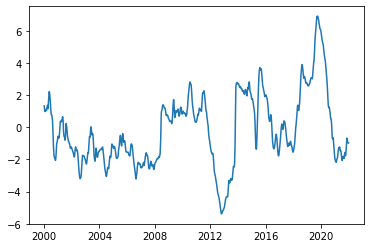

In [22]:
plt.plot(pdsi_df['2000-01-01':'2021-12-30'])

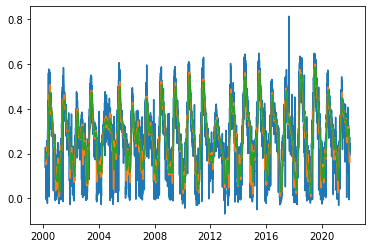

In [23]:
NDVI_df['SMA15'] = NDVI_df['mean'].rolling(15).mean()
NDVI_df['SMA30'] = NDVI_df['mean'].rolling(30).mean()
plt.plot(NDVI_df['2000-01-01':'2021-12-30'])

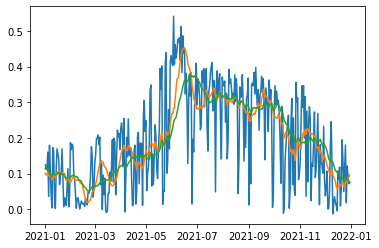

In [ ]:
PP_NDVI_df['SMA15'] = PP_NDVI_df['mean'].rolling(15).mean()
PP_NDVI_df['SMA30'] = PP_NDVI_df['mean'].rolling(30).mean()
plt.plot(PP_NDVI_df['2021-01-01':'2021-12-30'])

**Functions to Resample Data**

In [ ]:
def dataresample(df, cadence = 'M'):
  df_monthly = df.resample('M').mean() # W for weekly

  # Reset the index to a column
  df_monthly.reset_index(inplace=True)

  print(df_monthly)

In [ ]:
# Set the date column as the index
df.set_index('date', inplace=True)

# Group the data by day of the year and calculate the average for each day of the year
df_grouped = df.groupby(df.index.dayofyear).mean()

# Create a dictionary mapping day of year to average value
day_of_year_to_mean = df_grouped['value'].to_dict()

# Map the day of year to the average value for that day of year
df['day_of_year'] = df.index.dayofyear
df['day_of_year_mean'] = df['day_of_year'].map(day_of_year_to_mean)

# Calculate the daily anomaly as the difference between the original value and the average value for that day of year
df['anomaly'] = df['value'] - df['day_of_year_mean']

print(df)

In [ ]:
# sample script in Python that normalizes the values in a pandas dataframe using the MinMaxScaler method from the scikit-learn library:

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the data into a dataframe
df = pd.read_csv("data.csv")

# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler to the data
scaler.fit(df)

# Transform the data to have normalized values between 0 and 1
df_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns)

# Print the result
print(df_scaled)